In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/Vera/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Load data
schars = pd.read_csv('simpsons_characters.csv')
sepisodes = pd.read_csv('simpsons_episodes.csv')
slines = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)
locations = pd.read_csv('simpsons_locations.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False)

## Підготуємо та дослідимо дані

### Додамо дані про кількість персонажів у епізоді, кількість локацій та кількість слів

In [3]:
sepisodes['num_characters'] = 0
sepisodes['words_count'] = 0
sepisodes['num_locations'] = 0

for id in sepisodes['id']:
    num_characters = len(slines[slines['episode_id'] == id].dropna().character_id.drop_duplicates())
    words_count = slines[slines['episode_id'] == id].dropna().word_count.sum()
    num_locations = len(slines[slines['episode_id'] == id].dropna().location_id.drop_duplicates())
    sepisodes.set_value(sepisodes['id'] == id, 'num_characters', num_characters)
    sepisodes.set_value(sepisodes['id'] == id, 'words_count', words_count)
    sepisodes.set_value(sepisodes['id'] == id, 'num_locations', num_locations)
    
sepisodes[['id', 'num_characters', 'words_count', 'num_locations']].head(5)

,id,num_characters,words_count,num_locations
0,10,40,2521.0,28
1,12,33,2788.0,15
2,14,27,2646.0,18
3,17,28,2764.0,14
4,19,14,2688.0,13


### Додамо дані про головного героя епізоду, базуючих на кількості сказанних слів

In [4]:
main_characters = np.asarray(slines['raw_character_text'].value_counts().keys()[0:4])

In [5]:
sepisodes['main_character'] = 0

for id in sepisodes['id']:
    main_character = slines[slines['episode_id'] == id].dropna().groupby(['raw_character_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_character) and main_character[0] in main_characters):
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', main_character[0])
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_character', 'Else')

In [6]:
sepisodes[['id', 'main_character']].head(5)

,id,main_character
0,10,Homer Simpson
1,12,Else
2,14,Bart Simpson
3,17,Else
4,19,Homer Simpson


### Додамо дані про головну локацію епізоду

In [7]:
main_locations = np.asarray(slines['raw_location_text'].value_counts().keys()[0:4])

In [8]:
sepisodes['main_location'] = 0

for id in sepisodes['id']:
    main_location = slines[slines['episode_id'] == id].dropna().groupby(['raw_location_text'])['word_count'].sum().sort_values(ascending=False).keys()
    if (len(main_location) and main_location[0] in main_locations):
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', main_location[0])
    else:
        sepisodes.set_value(sepisodes['id'] == id, 'main_location', 'Elsewhere')

In [9]:
sepisodes[['id', 'main_location']].head(5)

,id,main_location
0,10,Elsewhere
1,12,Elsewhere
2,14,Elsewhere
3,17,Simpson Home
4,19,Elsewhere


## Кореляція мож кількостю переглядів (діалогів, кількості серії і тд) від рейтингу сезону

/Users/Vera/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


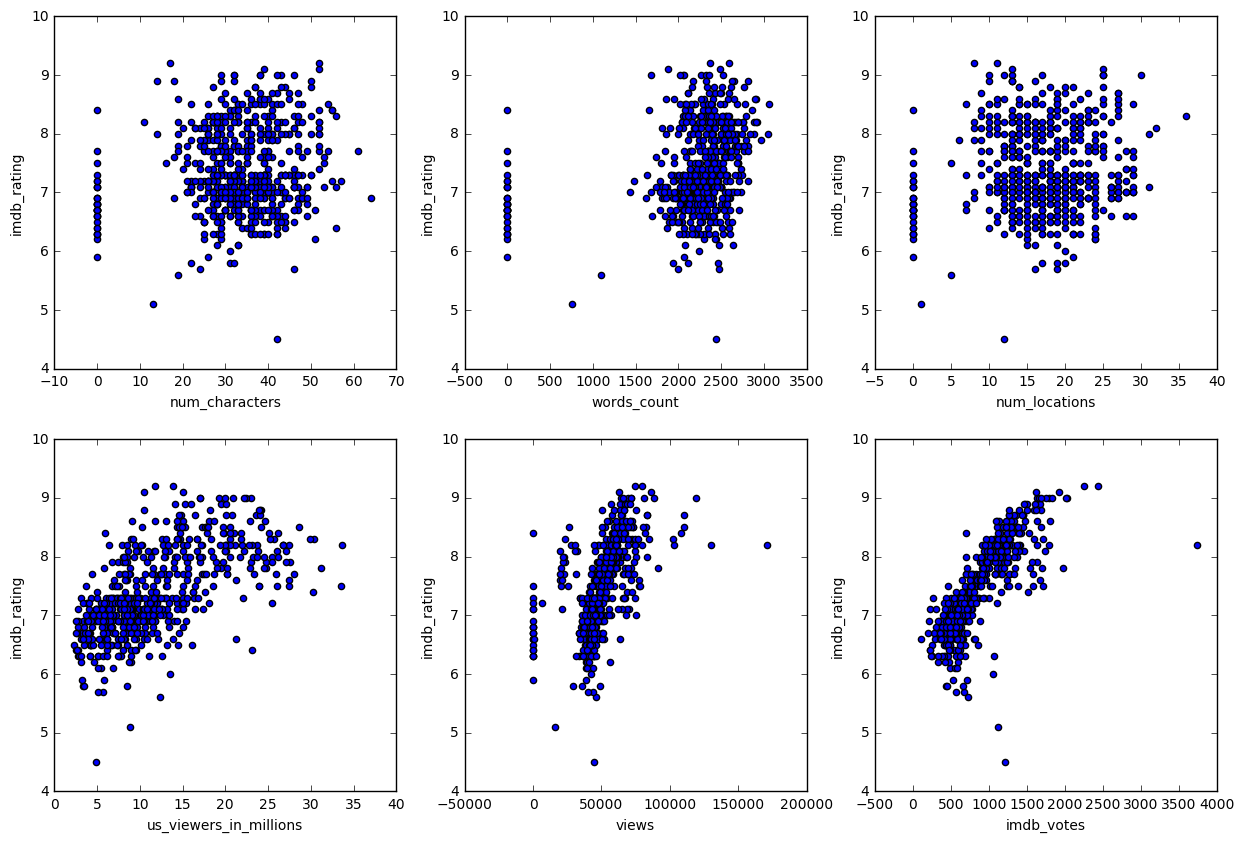

In [10]:
episodes_data = sepisodes[['num_characters', 'words_count', 'num_locations', 'us_viewers_in_millions','views','imdb_votes','imdb_rating']]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(episodes_data.columns[:-1]):
    episodes_data.plot(feature, "imdb_rating", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])

In [11]:
sepisodes[['num_characters', 'words_count', 'num_locations', 'main_character', 'main_location','us_viewers_in_millions','views','imdb_votes','imdb_rating']].corr()

,num_characters,words_count,num_locations,us_viewers_in_millions,views,imdb_votes,imdb_rating
num_characters,1.000000,0.643517,0.607055,0.205483,0.401335,0.167530,0.166147
words_count,0.643517,1.000000,0.562380,0.358101,0.487891,0.382006,0.293775
num_locations,0.607055,0.562380,1.000000,0.203796,0.351742,0.150915,0.116361
us_viewers_in_millions,0.205483,0.358101,0.203796,1.000000,0.551805,0.786840,0.623260
views,0.401335,0.487891,0.351742,0.551805,1.000000,0.668230,0.575512
imdb_votes,0.167530,0.382006,0.150915,0.786840,0.668230,1.000000,0.783829
imdb_rating,0.166147,0.293775,0.116361,0.623260,0.575512,0.783829,1.000000


In [12]:
data = sepisodes[['num_characters', 'words_count', 'num_locations', 'main_character', 'main_location','us_viewers_in_millions','views','imdb_votes','imdb_rating']]

In [13]:
data.to_csv('data.csv')